<a href="https://colab.research.google.com/github/Rishad-A-Pulok/Sign_Language_BdSL_Word/blob/main/BdSL_Word_Final_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet
from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
!unzip "/content/drive/MyDrive/Sign Language Project/BdSL_Word.zip"

Archive:  /content/drive/MyDrive/Sign Language Project/BdSL_Word.zip
   creating: Word/
   creating: Word/Color/
  inflating: Word/Color/color (1).jpg  
  inflating: Word/Color/color (10).jpg  
  inflating: Word/Color/color (11).jpg  
  inflating: Word/Color/color (12).jpg  
  inflating: Word/Color/color (13).jpg  
  inflating: Word/Color/color (14).jpg  
  inflating: Word/Color/color (15).jpg  
  inflating: Word/Color/color (16).jpg  
  inflating: Word/Color/color (17).jpg  
  inflating: Word/Color/color (18).jpg  
  inflating: Word/Color/color (19).jpg  
  inflating: Word/Color/color (2).jpg  
  inflating: Word/Color/color (20).jpg  
  inflating: Word/Color/color (21).jpg  
  inflating: Word/Color/color (22).jpg  
  inflating: Word/Color/color (23).jpg  
  inflating: Word/Color/color (24).jpg  
  inflating: Word/Color/color (25).jpg  
  inflating: Word/Color/color (26).jpg  
  inflating: Word/Color/color (27).jpg  
  inflating: Word/Color/color (28).jpg  
  inflating: Word/Color/colo

In [4]:
base_path = '/content/Word'

In [5]:
SIZE = 224
image_size = (SIZE, SIZE)
batch_size = 32
channels = 3
kernel = 4
stride = 1
pool = 2

(224, 224, 3)


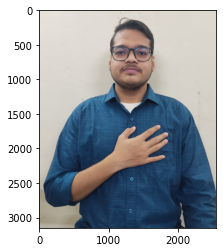

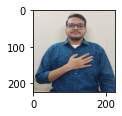

In [6]:
#show resized images
img = cv2.imread("/content/Word/Myself/myself (55).jpg")[:, :, ::-1]
width, height = SIZE, SIZE
resized_img = cv2.resize(img, (width, height))
plt.imshow(img)
plt.figure(figsize = (1.5, 1.5))
plt.imshow(resized_img)
print(resized_img.shape)

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)

Found 992 files belonging to 10 classes.
Using 794 files for training.
Found 992 files belonging to 10 classes.
Using 198 files for validation.


In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip= True,
    vertical_flip= False,
    validation_split= 0.2,
)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split= 0.2,
)

In [9]:
train_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
)
test_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = False,
    subset = 'validation'
)

Found 796 images belonging to 10 classes.
Found 196 images belonging to 10 classes.


In [10]:
test_set.class_indices

{'Color': 0,
 'Friend': 1,
 'Myself': 2,
 'Promise': 3,
 'Request': 4,
 'Salam': 5,
 'Surprise': 6,
 'They': 7,
 'Think': 8,
 'You': 9}

In [11]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['Color',
 'Friend',
 'Myself',
 'Promise',
 'Request',
 'Salam',
 'Surprise',
 'They',
 'Think',
 'You']

In [12]:
labels = ['Color','Friend','Myself','Promise','Request','Salam','Surprise','They','Think','You']

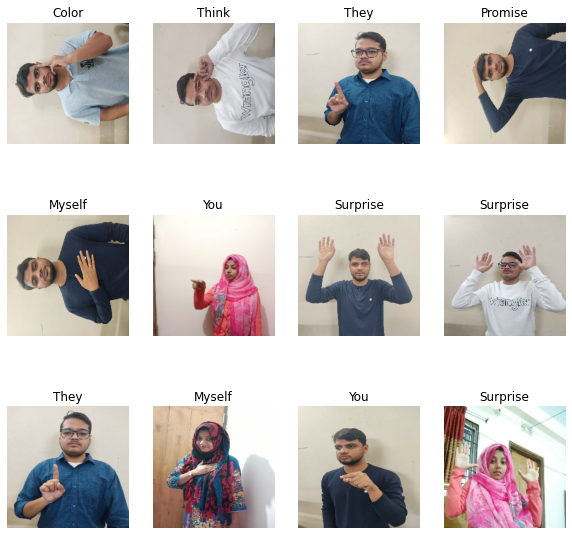

In [13]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in train_ds.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

#CNN Model

In [14]:
model=Sequential()

model.add(Conv2D(16,kernel_size=kernel,strides=stride,padding='same',activation='relu',input_shape=(SIZE, SIZE, channels)))
model.add(MaxPool2D(pool_size=pool,strides=2,padding='same'))

model.add(Conv2D(32,kernel_size=kernel,strides=stride,activation='relu',padding='same'))
model.add(MaxPool2D((pool),2,padding='same'))

model.add(Conv2D(64,kernel_size=kernel,strides=stride,activation='relu',padding='same'))
model.add(MaxPool2D((pool),2,padding='same'))
          
model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=num_classes,activation='softmax'))

In [15]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        32832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [16]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 35.6 MB/s 


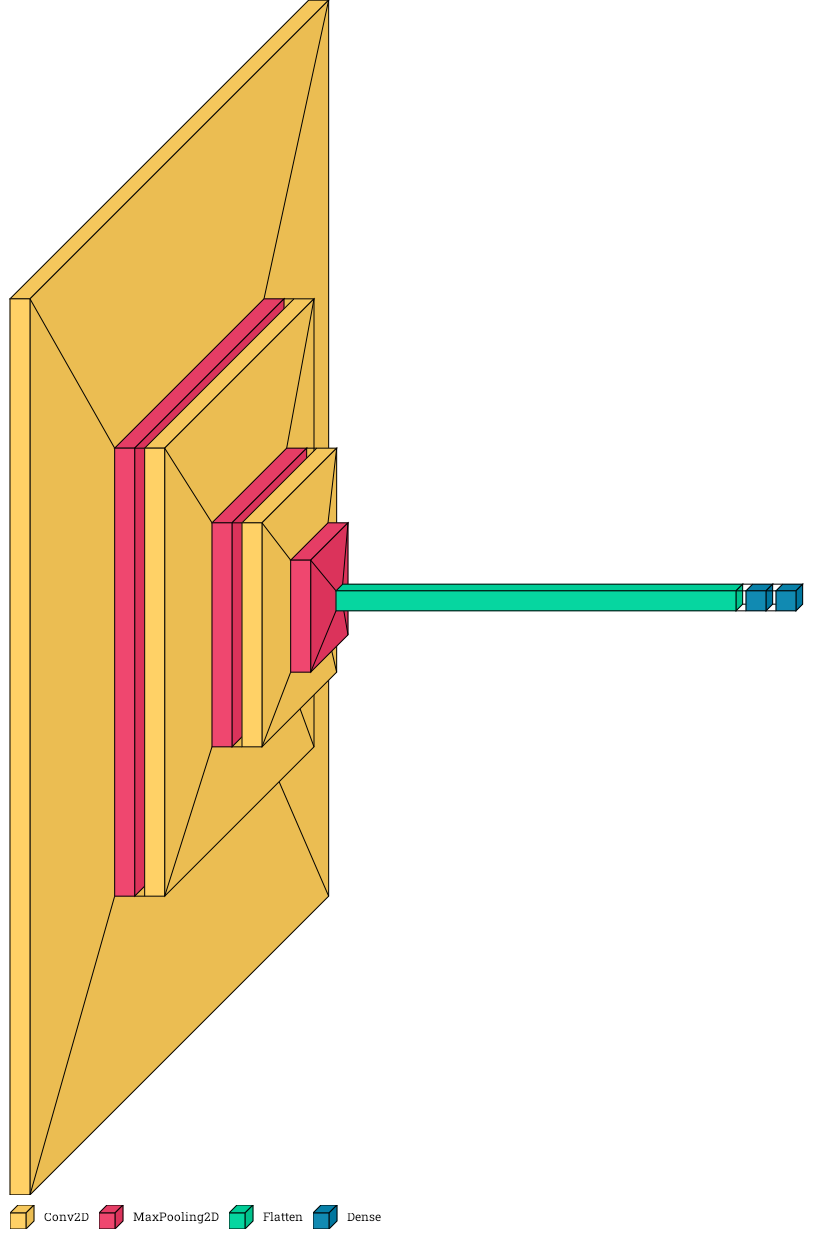

In [17]:
from PIL import ImageFont
import visualkeras
font = ImageFont.truetype("/content/drive/MyDrive/Sign Language Project/RobotoSlab-VariableFont_wght.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font)

In [18]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
history = model.fit( train_set, epochs=25, callbacks=model_checkpoint, validation_data=test_set)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 [==============================] - 136s 5s/step - loss: 2.3730 - accuracy: 0.1093 - val_loss: 2.2733 - val_accuracy: 0.1582
Epoch 2/25
25/25 [==============================] - 121s 5s/step - loss: 2.0394 - accuracy: 0.2613 - val_loss: 1.9205 - val_accuracy: 0.4184
Epoch 3/25
25/25 [==============================] - 122s 5s/step - loss: 1.5629 - accuracy: 0.4322 - val_loss: 1.4431 - val_accuracy: 0.5102
Epoch 4/25
25/25 [==============================] - 121s 5s/step - loss: 1.1882 - accuracy: 0.5754 - val_loss: 1.2307 - val_accuracy: 0.6327
Epoch 5/25
25/25 [==============================] - 120s 5s/step - loss: 1.0809 - accuracy: 0.6219 - val_loss: 1.2587 - val_accuracy: 0.5714
Epoch 6/25
25/25 [==============================] - 119s 5s/step - loss: 0.9535 - accuracy: 0.6633 - val_loss: 1.0997 - val_accuracy: 0.6224
Epoch 7/25
25/25 [==============================] - 121s 5s/step - loss: 0.7337 - accuracy: 0.7412 - val_loss: 1.3872 - val_accuracy: 0.5918
Epoch 8/25
25/25 [======

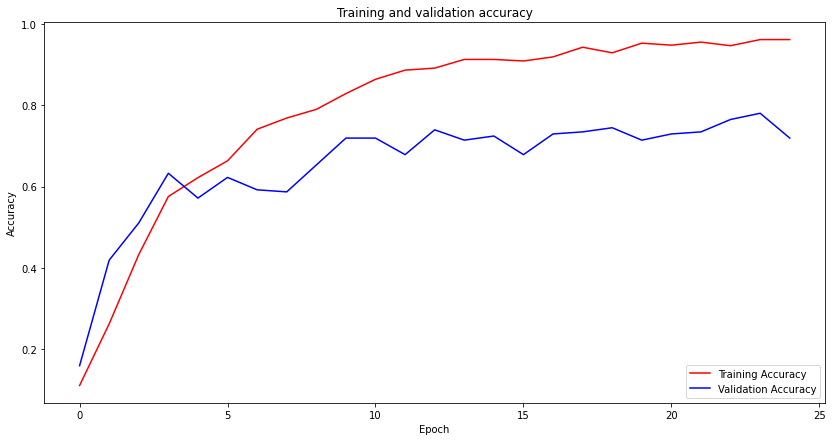

In [20]:
# Validation and Training accuracy plot
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

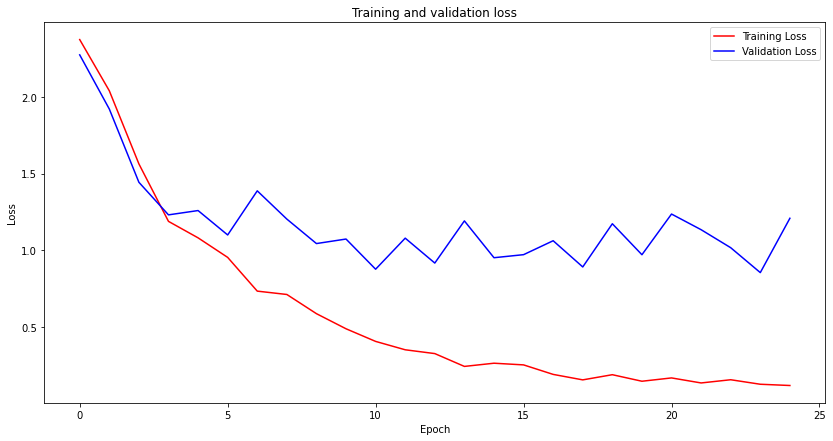

In [21]:
#Validation and Training loss plot
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

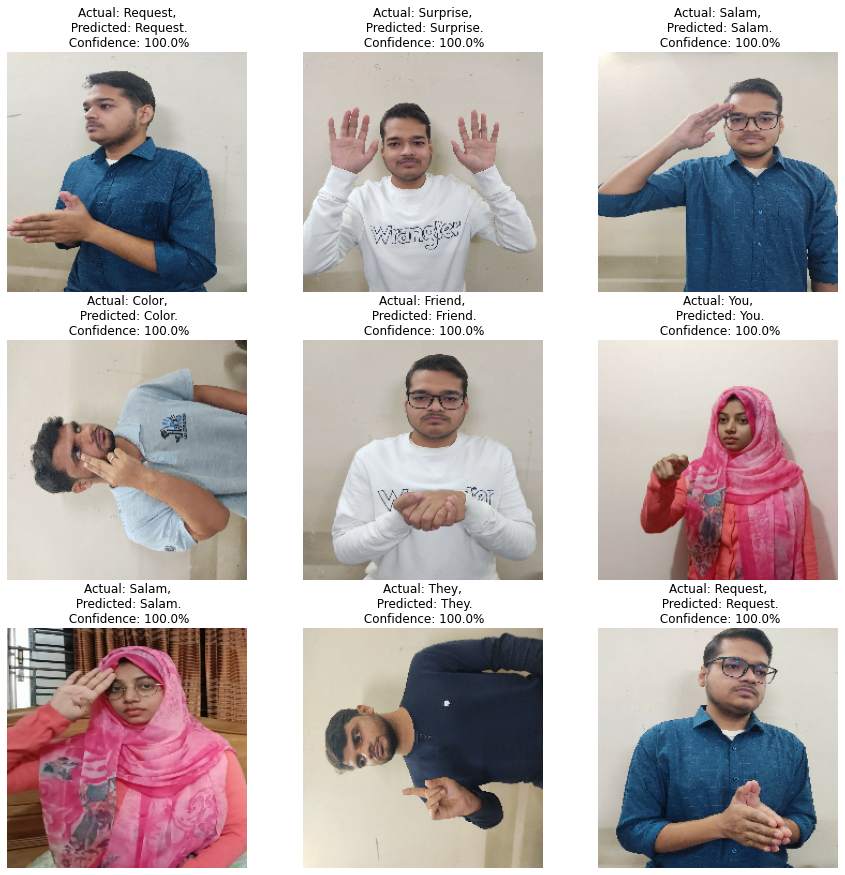

In [35]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predicted_class, confidence =predict(model, image_batch[i].numpy())
        actual_class = class_names[labels_batch[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [44]:
loss,test_accuracy = model.evaluate(test_set)
print('Accuracy on test:', test_accuracy)

7/7 [==============================] - 27s 4s/step - loss: 1.5103 - accuracy: 0.7653
Accuracy on test: 0.7653061151504517


In [45]:
# T0 print the Classification Report
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_set.classes, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.87      1.00      0.93        20
           2       0.76      0.62      0.68        21
           3       0.81      0.94      0.87        18
           4       0.39      0.57      0.46        21
           5       0.90      0.95      0.92        19
           6       0.95      0.90      0.92        20
           7       0.61      0.58      0.59        19
           8       0.94      0.81      0.87        21
           9       0.55      0.32      0.40        19

    accuracy                           0.76       196
   macro avg       0.77      0.76      0.76       196
weighted avg       0.77      0.76      0.76       196



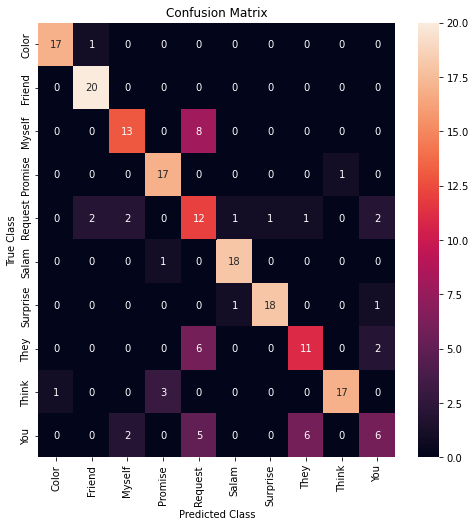

In [46]:
import seaborn as sns
# To print the Confusion Matrix
cf_matrix = confusion_matrix(test_set.classes, y_pred)
labels = ['Color','Friend','Myself','Promise','Request','Salam','Surprise','They','Think','You']
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()